# Sunspots Time Series Analysis with SARIMA


### Do the number of sunspots observed follow a seasonal pattern?

Sunspots, cooler and visibly darker areas on the Sun, are caused by the Sun's magnetic field (https://science.nasa.gov/sun/sunspots/). The Sun's plasma can cause magnetic field lines to twist, creating snarls that stop heat from rising to the surface. The Sun is known to have a cycle of 11 years -- this is when the magnetic poles flip. The aim of this project is to model the Sun's solar cycle using sunspot data.

The daily sunspot dataset contains observations from 1818-2019. The total sunspot number is calculated from R = N + 10 * N_groups, where N is the number of spots and N_groups is the number of groups on the solar disk (https://www.sidc.be/SILSO/infosndtot).

Seasonal Autoregressive Integrated Moving Average (SARIMA) is a time series forecasting model specifically for seasonal patterns (https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/). Hence, SARIMA is used in this analysis to model the total sunspot number over time. SARIMA includes autoregressive (AR), integrated (I), and moving average (MA) components. The S is the seasonal component, representing recurring patterns at regular intervals such as daily. The AR component captures the correlation between the current observation and previous values. The I component captures how many differences are necessary for stationarity, a requirement of time series modeling. Finally, the MA component accounts for short-term noise.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Data Gathering & Understanding

In [2]:
sunspots = pd.read_csv('sunspot_data.csv') # data from kaggle https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019/data
                                           # original source https://www.sidc.be/SILSO/infosndtot
display(sunspots.describe())

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
count,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000
mean,36858.500000,1918.416750,6.518896,15.729347,1918.916406,79.248732,6.924587,4.429678,0.998331
std,21280.697909,58.264401,3.447114,8.800032,58.264520,77.470942,4.778793,7.884112,0.040814
min,0.000000,1818.000000,1.000000,1.000000,1818.001000,-1.000000,-1.000000,0.000000,0.000000
25%,18429.250000,1868.000000,4.000000,8.000000,1868.458500,15.000000,3.000000,1.000000,1.000000
50%,36858.500000,1918.000000,7.000000,16.000000,1918.917500,58.000000,6.600000,1.000000,1.000000
75%,55287.750000,1969.000000,10.000000,23.000000,1969.373250,125.000000,10.000000,1.000000,1.000000
max,73717.000000,2019.000000,12.000000,31.000000,2019.832000,528.000000,77.700000,60.000000,1.000000


### Data Cleaning

These cells clean the column names, check missingness, and filter out the years with missing data.

In [3]:
sunspots.columns = [re.sub(r'\s','_', i.lower()) for i in sunspots.columns] # replace spaces with underscore, make columns lowercase
sunspots = sunspots.iloc[:, 1:] # drop first column representing index
display(sunspots.head())

,year,month,day,date_in_fraction_of_year,number_of_sunspots,standard_deviation,observations,indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


<function matplotlib.pyplot.show(close=None, block=None)>

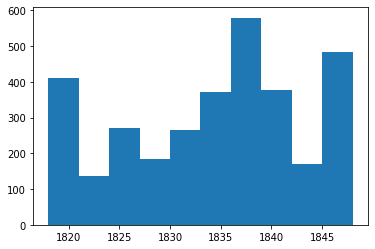

In [4]:
# checking missing data
len(sunspots[sunspots['observations']==0])/len(sunspots[sunspots['observations']>0]) # 4% missing obs encoded as -1
latest_missing_year = max(sunspots[sunspots['observations']==0].year)
plt.hist(sunspots[sunspots['number_of_sunspots'] == -1].year)
plt.show

In [5]:
latest_missing_year

1848

All of the missing data is before 1848 (inclusive). Due to the high level of missingness during these years, backfilling and imputing are not justified; the dataset is simply filtered to exclude the years with missing data.

In [6]:
# filter data to only include datapoints after most recent year
sunspots_filtered = sunspots.query('year > {}'.format(latest_missing_year)).copy()

In [7]:
# date must be in datetime format as index to run SARIMA
sunspots_filtered['date'] = pd.to_datetime(sunspots_filtered[['year', 'month', 'day']])
sunspots_filtered = sunspots_filtered.set_index('date')

,year,month,day,date_in_fraction_of_year,number_of_sunspots,standard_deviation,observations,indicator
date,,,,,,,,
1870-08-26,1870,8,26,1870.651,528,25.8,1,1
1870-08-27,1870,8,27,1870.653,520,25.6,1,1
1870-08-29,1870,8,29,1870.659,518,25.6,1,1
1957-12-24,1957,12,24,1957.979,503,15.1,1,1
1957-12-25,1957,12,25,1957.982,503,15.1,1,1


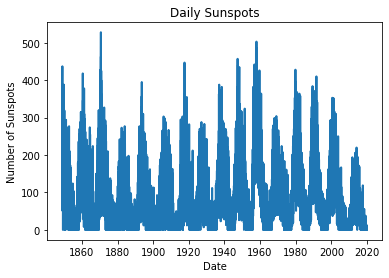

In [8]:
display(sunspots_filtered.sort_values('number_of_sunspots', ascending = False).head())

plt.plot(sunspots_filtered['number_of_sunspots'], linewidth = 2)
plt.title('Daily Sunspots')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show()

### SARIMA Analysis

#### Check Stationarity Assumption

Before applying time series model SARIMA, we must check the stationarity assumption. The Augmented Dickey-Fuller (ADF) test is used to determine stationarity.

In [9]:
num_sunspots = sunspots_filtered.number_of_sunspots.resample('Q').mean()
adf_output = adfuller(num_sunspots, autolag='AIC')

print('ADF Statistic: {}'.format(adf_output[0]))
print('p-value: {}'.format(adf_output[1]))

if adf_output[1] < 0.05:
    print('Stationary')
else:
    print('Non-Stationary')

ADF Statistic: -9.389680011546577
p-value: 6.612617975892046e-16
Stationary


The p-value of 6.61e-16 indicates the observations, which were resampled to be quarterly, are stationary. Next, autocorrelation and partial autocorrelationn plots are used to determine the parameter values.

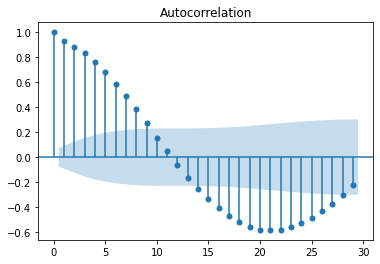

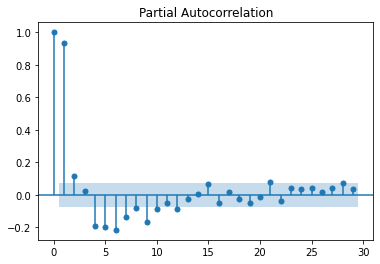

In [10]:
plot_acf(num_sunspots)
plot_pacf(num_sunspots)
plt.show()

For ACF plot, initial spikes at lags <= 9, implying q<=9. From p-values in the next cell, the best result is at q=1 and Q=0.

For PACF plot, initial spikes at lags <= 3, implying p<=3. From p-values in the next cell, the best result is at p=1 and P=2.

Based on the known cycle of the sun's magnetic field, the seasonality is 11 years * 4 quarters in a year = 44. 

In [11]:
# define parameters
p, d, q = 1, 0, 1
P, D, Q, s = 2, 1, 0, 44
model = SARIMAX(num_sunspots, trend = 'n', order=(p, d, q), seasonal_order = (P, D, Q, s))
results = model.fit()

In [12]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  number_of_sunspots   No. Observations:                  684
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 44)   Log Likelihood               -2969.205
Date:                             Tue, 03 Dec 2024   AIC                           5948.409
Time:                                     09:50:20   BIC                           5970.717
Sample:                                 03-31-1849   HQIC                          5957.068
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.013     70.761      0.000       0.898       0.950
ma.L1         -0.2534      

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


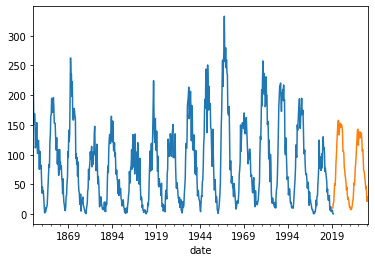

In [13]:
forecast = results.predict(start = num_sunspots.index[-2], end = num_sunspots.index[-2] + pd.DateOffset(months = 240), dynamic = True)
num_sunspots.plot()
forecast.plot()
plt.show()

### Conclusion
Sunspot data does have a stationary, seasonal pattern that reflects the magnetic field's cycle. Some periods have a higher peak, such as 1959. More research into the sun's natural cycles may provide insight into why this period is unique.

Future research should leverage grid search to determine the optimal combination of parameters and report accuracy measures. This analysis simply used visual interpretations and trial and error to find a suitable combination of parameters. Grid search would lead to a more robust analysis. 